# 基于计算机视觉的钢筋条数检测

数据集：钢筋进工地现场的图片和标注文件，250张训练，200张测试

实现方案：基于目标检测，检测出图片中钢筋的横截面，从而统计出钢筋的条数

### 进入ModelArts
点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面

### 创建ModelArts notebook
下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”
![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

|项目|建议填写方式|
|-|-|
|名称|自定义环境名称|
|工作环境 | Python3|
| 资源池 | 选择\"公共资源池\"即可 |
|类型|GPU|
|规格|GPU:1*p100, CPU:8核64GiB|
|存储配置|EVS|
|磁盘规格|5GB|

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建“
![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境
接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook。
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的\"New\"，然后选择**Pytorch-1.0.0**开发环境。

第三步：点击左上方的文件名\"Untitled\"，并输入一个与本实践相关的名称，如“rebar_count”。

### 在Notebook中编写并执行代码
在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)

开发环境准备好啦，接下来可以愉快地写代码啦！


# 下载代码和数据集

In [1]:
import os
import moxing as mox
if not os.path.exists('./rebar_count'):
    print('Downloading code and datasets...')
    mox.file.copy('s3://modelarts-labs-bj4/notebook/DL_rebar_count/rebar_count.zip', './rebar_count.zip')
    os.system("unzip rebar_count.zip; rm rebar_count.zip")
    if os.path.exists('./rebar_count'):
        print('Download code and datasets success')
    else:
        print('Download code and datasets failed, please check the download url is valid or not.')
else:
    print('./rebar_count already exists')

INFO:root:Using MoXing-v1.14.0-14d5d81b
INFO:root:Using OBS-Python-SDK-3.1.2


Download code and datasets success


# 加载需要的python模块

In [2]:
import os
import sys
sys.path.insert(0, './rebar_count/src')
import cv2
import time
import torch
import numpy as np
from PIL import Image
from datetime import datetime
from collections import OrderedDict
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from data import VOCroot, VOC_Config, AnnotationTransform, VOCDetection, detection_collate, BaseTransform, preproc
from models.RFB_Net_vgg import build_net
from layers.modules import MultiBoxLoss
from layers.functions import Detect, PriorBox
from utils.visualize import *
from utils.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_DIR = os.getcwd()

INFO:matplotlib.font_manager:font search path ['/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf', '/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/afm', '/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
INFO:matplotlib.font_manager:generated new fontManager


# 查看训练数据样例

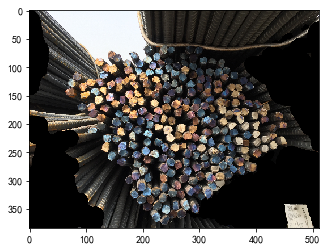

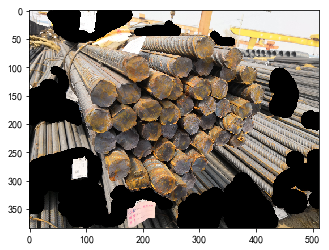

In [3]:
train_img_dir = './rebar_count/datasets/VOC2007/JPEGImages'
files = os.listdir(train_img_dir)
for index, file_name in enumerate(files[:2]):
    img = Image.open(os.path.join(train_img_dir, file_name))
    resize_scale = 512.0 / max(img.size)
    img = img.resize((int(img.size[0] * resize_scale), int(img.size[1] * resize_scale)))
    plt.figure(index)
    plt.imshow(img)
    plt.show()

# 定义训练超参，模型、日志保存路径

In [4]:
# 定义训练超参
num_classes = 2
max_epoch = 40
batch_size = 8
ngpu = 1
initial_lr = 0.01
img_dim = 416
train_sets = [('2007', 'trainval')]
cfg = VOC_Config
rgb_means = (104, 117, 123)

save_folder = './rebar_count/model_snapshots'  # 指定训练模型保存路径
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
log_path = os.path.join('./rebar_count/logs', datetime.now().isoformat())
if not os.path.exists(log_path):
    os.makedirs(log_path)

# 构建模型，定义优化器及损失函数

In [5]:
net = build_net('train', img_dim, num_classes=num_classes)

if ngpu > 1:
    net = torch.nn.DataParallel(net)

net.cuda()
cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=initial_lr,
                      momentum=0.9, weight_decay=0)

criterion = MultiBoxLoss(num_classes,
                         overlap_thresh=0.4,
                         prior_for_matching=True,
                         bkg_label=0,
                         neg_mining=True,
                         neg_pos=3,
                         neg_overlap=0.3,
                         encode_target=False)

priorbox = PriorBox(cfg)
with torch.no_grad():
    priors = priorbox.forward()
    priors = priors.cuda()

# 定义自适应学习率函数

In [6]:
def adjust_learning_rate(optimizer, gamma, epoch, step_index, iteration, epoch_size):
    """
    自适应学习率
    """
    if epoch < 11:
        lr = 1e-8 + (initial_lr-1e-8) * iteration / (epoch_size * 10)
    else:
        lr = initial_lr * (gamma ** (step_index))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

# 定义训练函数

In [7]:
def train():
    """
    模型训练函数，每10次迭代打印一次日志，20个epoch之后，每5个epoch保存一次模型
    """
    net.train()

    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading dataset...')

    dataset = VOCDetection(VOCroot, train_sets, preproc(img_dim, rgb_means, p=0.0), AnnotationTransform())

    epoch_size = len(dataset) // batch_size
    max_iter = max_epoch * epoch_size

    stepvalues = (25 * epoch_size, 35 * epoch_size)
    step_index = 0
    start_iter = 0

    lr = initial_lr
    for iteration in range(start_iter, max_iter):
        if iteration % epoch_size == 0:
            if (epoch > 20 and epoch % 5 == 0):
                torch.save(net.state_dict(), os.path.join(save_folder, 'epoch_' +
                           repr(epoch).zfill(3) + '_loss_'+ '%.4f' % loss.item() + '.pth'))

            batch_iterator = iter(data.DataLoader(dataset, batch_size,
                                                  shuffle=True, num_workers=8, collate_fn=detection_collate))
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        load_t0 = time.time()
        if iteration in stepvalues:
            step_index += 1
        lr = adjust_learning_rate(optimizer, 0.2, epoch, step_index, iteration, epoch_size)


        images, targets = next(batch_iterator)

        images = Variable(images.cuda())
        targets = [Variable(anno.cuda()) for anno in targets]

        # forward
        t0 = time.time()
        out = net(images)
        # backprop
        optimizer.zero_grad()
        loss_l, loss_c = criterion(out, priors, targets)
        loss = loss_l + loss_c
        loss.backward()
        optimizer.step()
        t1 = time.time()
        loc_loss += loss_l.item()
        conf_loss += loss_c.item()
        load_t1 = time.time()

        if iteration % 10 == 0:
            print('Epoch:' + repr(epoch) + ' || epochiter: ' + repr(iteration % epoch_size) + '/' + repr(epoch_size)
                  + '|| Totel iter ' +
                  repr(iteration) + ' || L: %.4f C: %.4f||' % (
                loss_l.item(),loss_c.item()) +
                'Batch time: %.4f sec. ||' % (load_t1 - load_t0) + 'LR: %.8f' % (lr))

    torch.save(net.state_dict(), os.path.join(save_folder, 'epoch_' +
               repr(epoch).zfill(3) + '_loss_'+ '%.4f' % loss.item() + '.pth'))

# 开始训练，总耗时约12分钟

In [8]:
t1 = time.time()
train()
print('training cost %.2f s' % (time.time() - t1))

Loading dataset...
Epoch:1 || epochiter: 0/25|| Totel iter 0 || L: 3.7308 C: 3.2263||Batch time: 7.3228 sec. ||LR: 0.00000001
Epoch:1 || epochiter: 10/25|| Totel iter 10 || L: 3.3674 C: 2.8529||Batch time: 0.1971 sec. ||LR: 0.00040001
Epoch:1 || epochiter: 20/25|| Totel iter 20 || L: 3.0520 C: 2.3914||Batch time: 0.1369 sec. ||LR: 0.00080001
Epoch:2 || epochiter: 5/25|| Totel iter 30 || L: 2.4989 C: 2.1347||Batch time: 0.2273 sec. ||LR: 0.00120001
Epoch:2 || epochiter: 15/25|| Totel iter 40 || L: 1.9585 C: 1.9029||Batch time: 0.3874 sec. ||LR: 0.00160001
Epoch:3 || epochiter: 0/25|| Totel iter 50 || L: 1.8100 C: 1.6681||Batch time: 5.6832 sec. ||LR: 0.00200001
Epoch:3 || epochiter: 10/25|| Totel iter 60 || L: 1.6106 C: 1.7244||Batch time: 0.2398 sec. ||LR: 0.00240001
Epoch:3 || epochiter: 20/25|| Totel iter 70 || L: 1.8082 C: 2.0507||Batch time: 0.1359 sec. ||LR: 0.00280001
Epoch:4 || epochiter: 5/25|| Totel iter 80 || L: 1.6934 C: 1.5977||Batch time: 0.2281 sec. ||LR: 0.00320001
Epoch

Epoch:31 || epochiter: 0/25|| Totel iter 750 || L: 0.3901 C: 0.6089||Batch time: 5.1189 sec. ||LR: 0.00200000
Epoch:31 || epochiter: 10/25|| Totel iter 760 || L: 0.3743 C: 0.5526||Batch time: 0.1912 sec. ||LR: 0.00200000
Epoch:31 || epochiter: 20/25|| Totel iter 770 || L: 0.5187 C: 0.6345||Batch time: 0.1679 sec. ||LR: 0.00200000
Epoch:32 || epochiter: 5/25|| Totel iter 780 || L: 0.4569 C: 0.6707||Batch time: 0.4099 sec. ||LR: 0.00200000
Epoch:32 || epochiter: 15/25|| Totel iter 790 || L: 0.3958 C: 0.5920||Batch time: 0.3302 sec. ||LR: 0.00200000
Epoch:33 || epochiter: 0/25|| Totel iter 800 || L: 0.3875 C: 0.6347||Batch time: 4.9493 sec. ||LR: 0.00200000
Epoch:33 || epochiter: 10/25|| Totel iter 810 || L: 0.4287 C: 0.6365||Batch time: 0.5079 sec. ||LR: 0.00200000
Epoch:33 || epochiter: 20/25|| Totel iter 820 || L: 0.4438 C: 0.5925||Batch time: 0.3163 sec. ||LR: 0.00200000
Epoch:34 || epochiter: 5/25|| Totel iter 830 || L: 0.3855 C: 0.5798||Batch time: 0.1953 sec. ||LR: 0.00200000
Epoch

# 定义目标检测类

In [9]:
cfg = VOC_Config
img_dim = 416
rgb_means = (104, 117, 123)

priorbox = PriorBox(cfg)
with torch.no_grad():
    priors = priorbox.forward()
    if torch.cuda.is_available():
        priors = priors.cuda()

class ObjectDetector:
    """
    定义目标检测类
    """
    def __init__(self, net, detection, transform, num_classes=num_classes, thresh=0.01, cuda=True):
        self.net = net
        self.detection = detection
        self.transform = transform
        self.num_classes = num_classes
        self.thresh = thresh
        self.cuda = torch.cuda.is_available()

    def predict(self, img):
        _t = {'im_detect': Timer(), 'misc': Timer()}
        scale = torch.Tensor([img.shape[1], img.shape[0],
                              img.shape[1], img.shape[0]])

        with torch.no_grad():
            x = self.transform(img).unsqueeze(0)
            if self.cuda:
                x = x.cuda()
                scale = scale.cuda()

        _t['im_detect'].tic()
        out = net(x)  # forward pass
        boxes, scores = self.detection.forward(out, priors)
        detect_time = _t['im_detect'].toc()
        boxes = boxes[0]
        scores = scores[0]

        # scale each detection back up to the image
        boxes *= scale
        boxes = boxes.cpu().numpy()
        scores = scores.cpu().numpy()
        _t['misc'].tic()
        all_boxes = [[] for _ in range(num_classes)]

        for j in range(1, num_classes):
            inds = np.where(scores[:, j] > self.thresh)[0]
            if len(inds) == 0:
                all_boxes[j] = np.zeros([0, 5], dtype=np.float32)
                continue
            c_bboxes = boxes[inds]
            c_scores = scores[inds, j]
            c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(
                np.float32, copy=False)

            keep = nms(c_dets, 0.2, force_cpu=False)
            c_dets = c_dets[keep, :]
            all_boxes[j] = c_dets

        nms_time = _t['misc'].toc()
        total_time = detect_time + nms_time

        return all_boxes, total_time

# 定义推理网络，并加载前面训练的loss最低的模型

In [10]:
trained_models = os.listdir(os.path.join(ROOT_DIR, './rebar_count/model_snapshots'))  # 模型文件所在目录
lowest_loss = 9999
best_model_name = ''
for model_name in trained_models:
    if not model_name.endswith('pth'):
        continue
    loss = float(model_name.split('_loss_')[1].split('.pth')[0])
    if loss < lowest_loss:
        lowest_loss = loss
        best_model_name = model_name
best_model_path = os.path.join(ROOT_DIR, './rebar_count/model_snapshots', best_model_name)

print('loading model from', best_model_path)
net = build_net('test', img_dim, num_classes)  # 加载模型
state_dict = torch.load(best_model_path)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    head = k[:7]
    if head == 'module.':
        name = k[7:]
    else:
        name = k
    new_state_dict[name] = v
net.load_state_dict(new_state_dict)
net.eval()
print('Finish load model!')

if torch.cuda.is_available():
    net = net.cuda()
    cudnn.benchmark = True
else:
    net = net.cpu()

detector = Detect(num_classes, 0, cfg)
transform = BaseTransform(img_dim, rgb_means, (2, 0, 1))
object_detector = ObjectDetector(net, detector, transform)

loading model from /home/ma-user/work/case_dev/DL_rebar_count/./rebar_count/model_snapshots/epoch_040_loss_1.0251.pth
Finish load model!


# 测试图片，输出每条钢筋的位置和图片中钢筋总条数

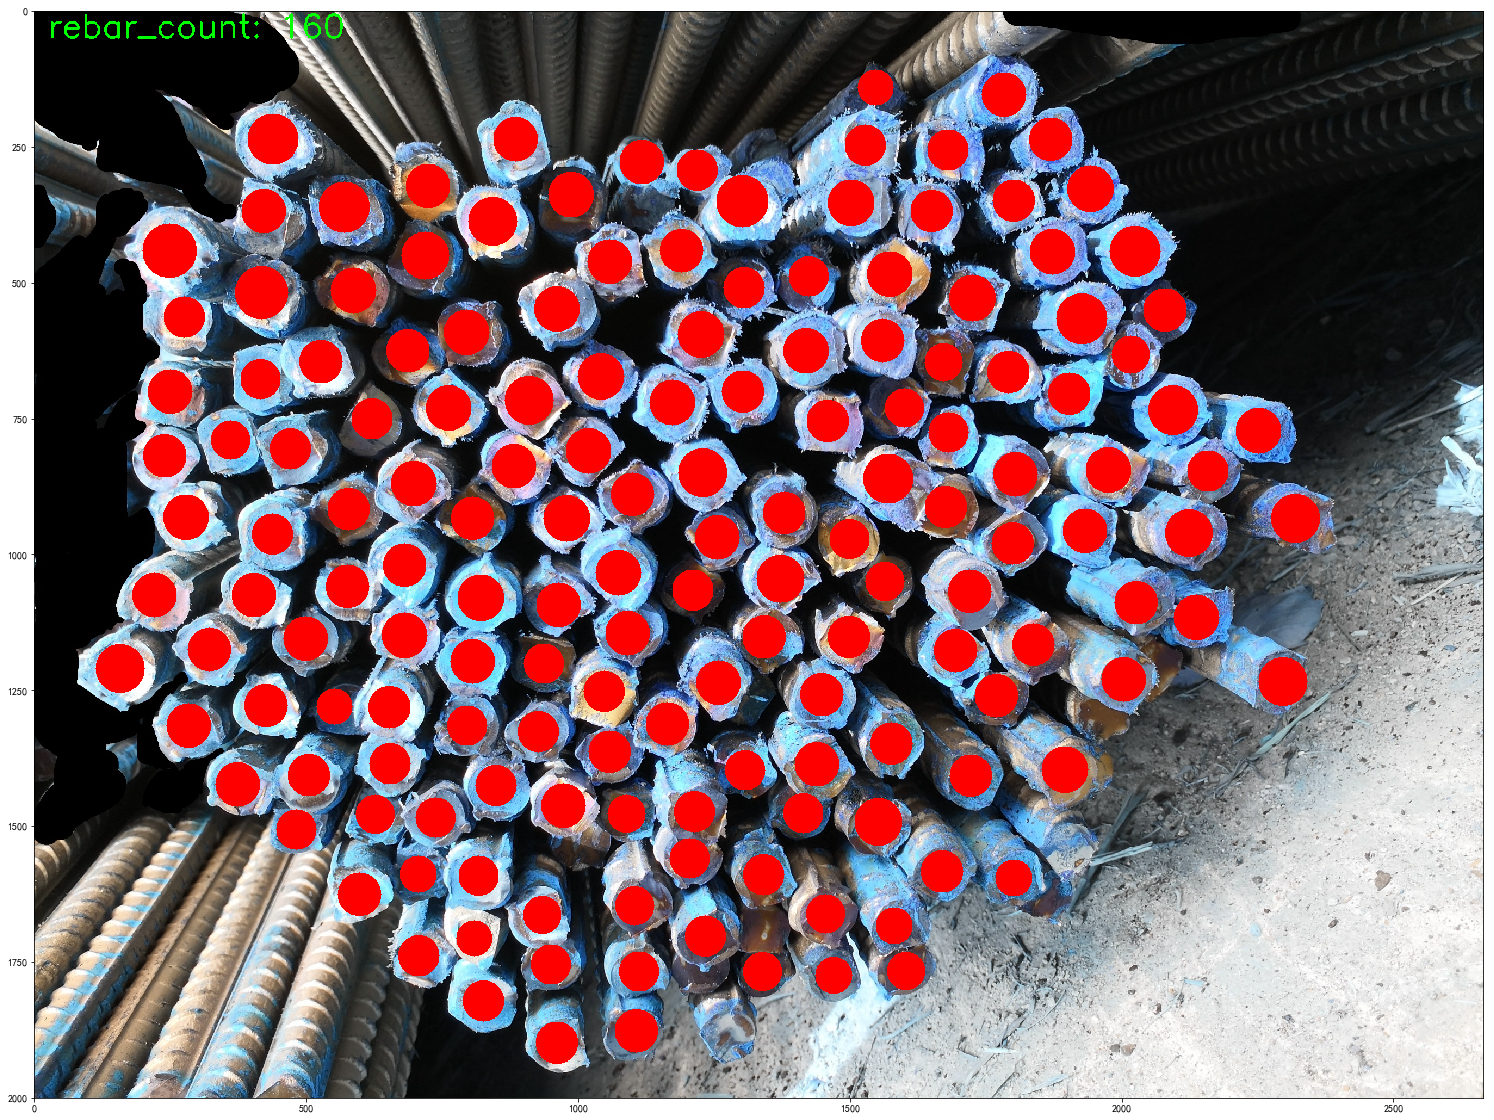

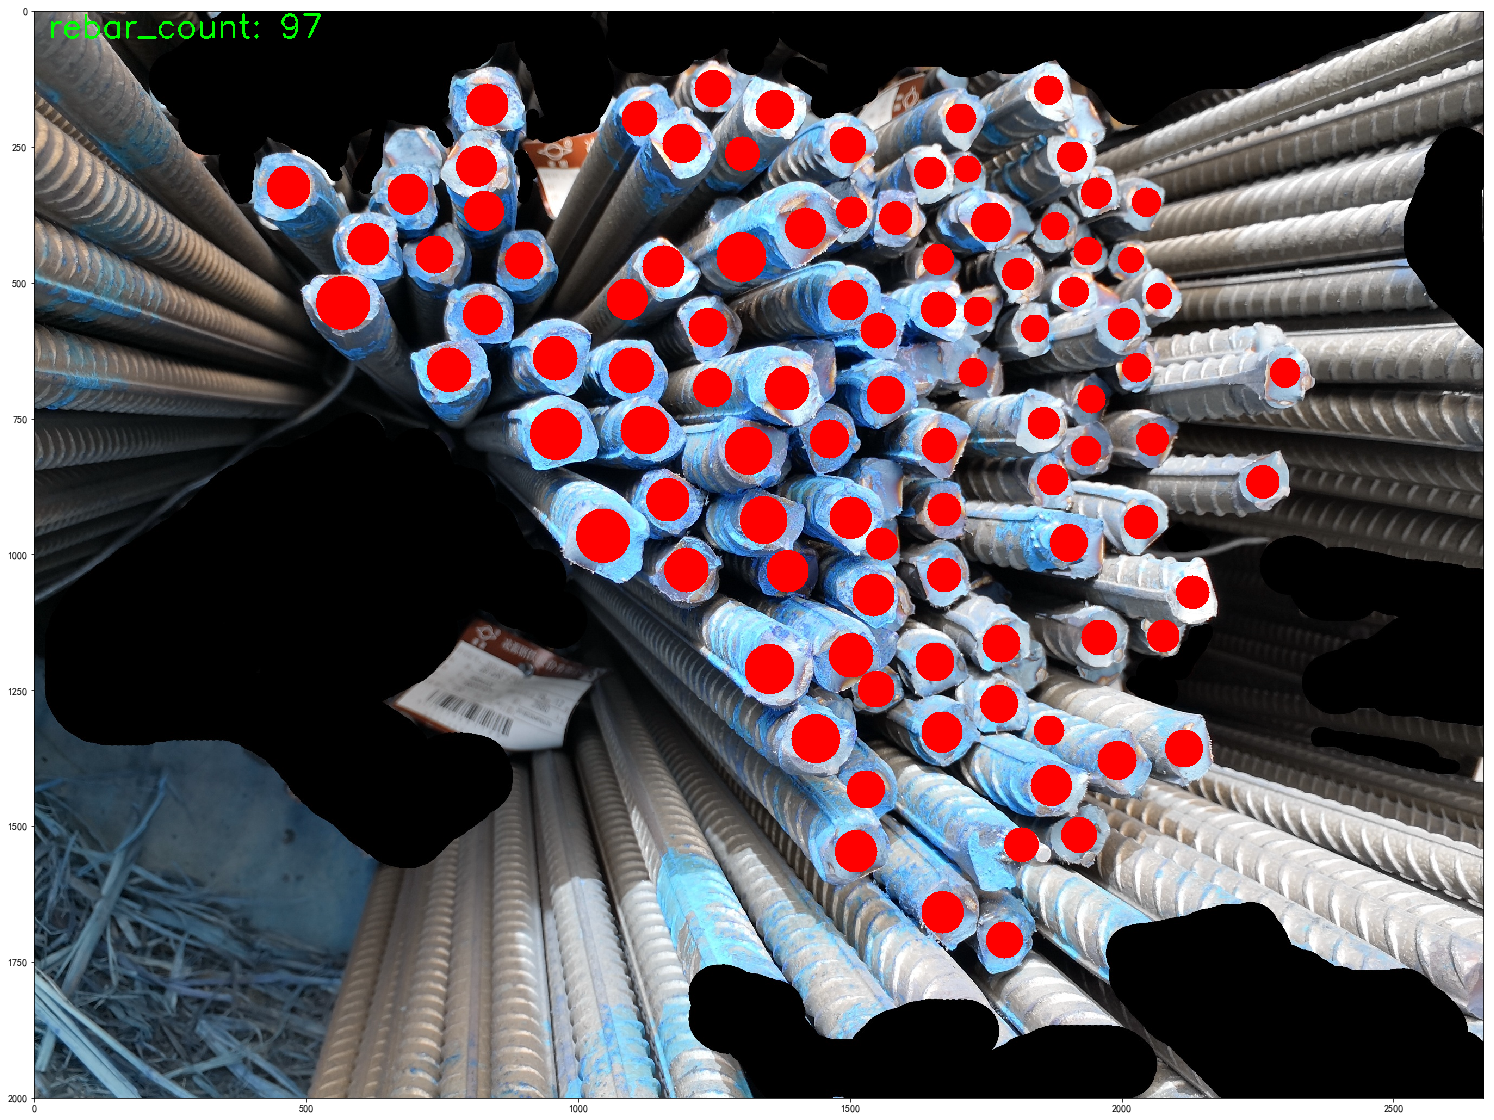

In [11]:
test_img_dir = r'./rebar_count/datasets/test_dataset'  # 待预测的图片目录
files = os.listdir(test_img_dir)[:2]
for i, file_name in enumerate(files):
    image_src = cv2.imread(os.path.join(test_img_dir, file_name))
    detect_bboxes, tim = object_detector.predict(image_src)
    image_draw = image_src.copy()
    rebar_count = 0
    for class_id, class_collection in enumerate(detect_bboxes):
        if len(class_collection) > 0:
            for i in range(class_collection.shape[0]):
                if class_collection[i, -1] > 0.6:
                    pt = class_collection[i]
                    cv2.circle(image_draw, (int((pt[0] + pt[2]) * 0.5), int((pt[1] + pt[3]) * 0.5)), int((pt[2] - pt[0]) * 0.5 * 0.6), (255, 0, 0), -1)
                    rebar_count += 1
    cv2.putText(image_draw, 'rebar_count: %d' % rebar_count, (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
    plt.figure(i, figsize=(30, 20))
    plt.imshow(image_draw)
    plt.show()

[参考资料](https://github.com/songwsx/steel-detect)